# Further Reading

##  Job Result

**The webpage based on the bokeh server povide detailed information needed by computational chemists which roughtly include the four parts.**

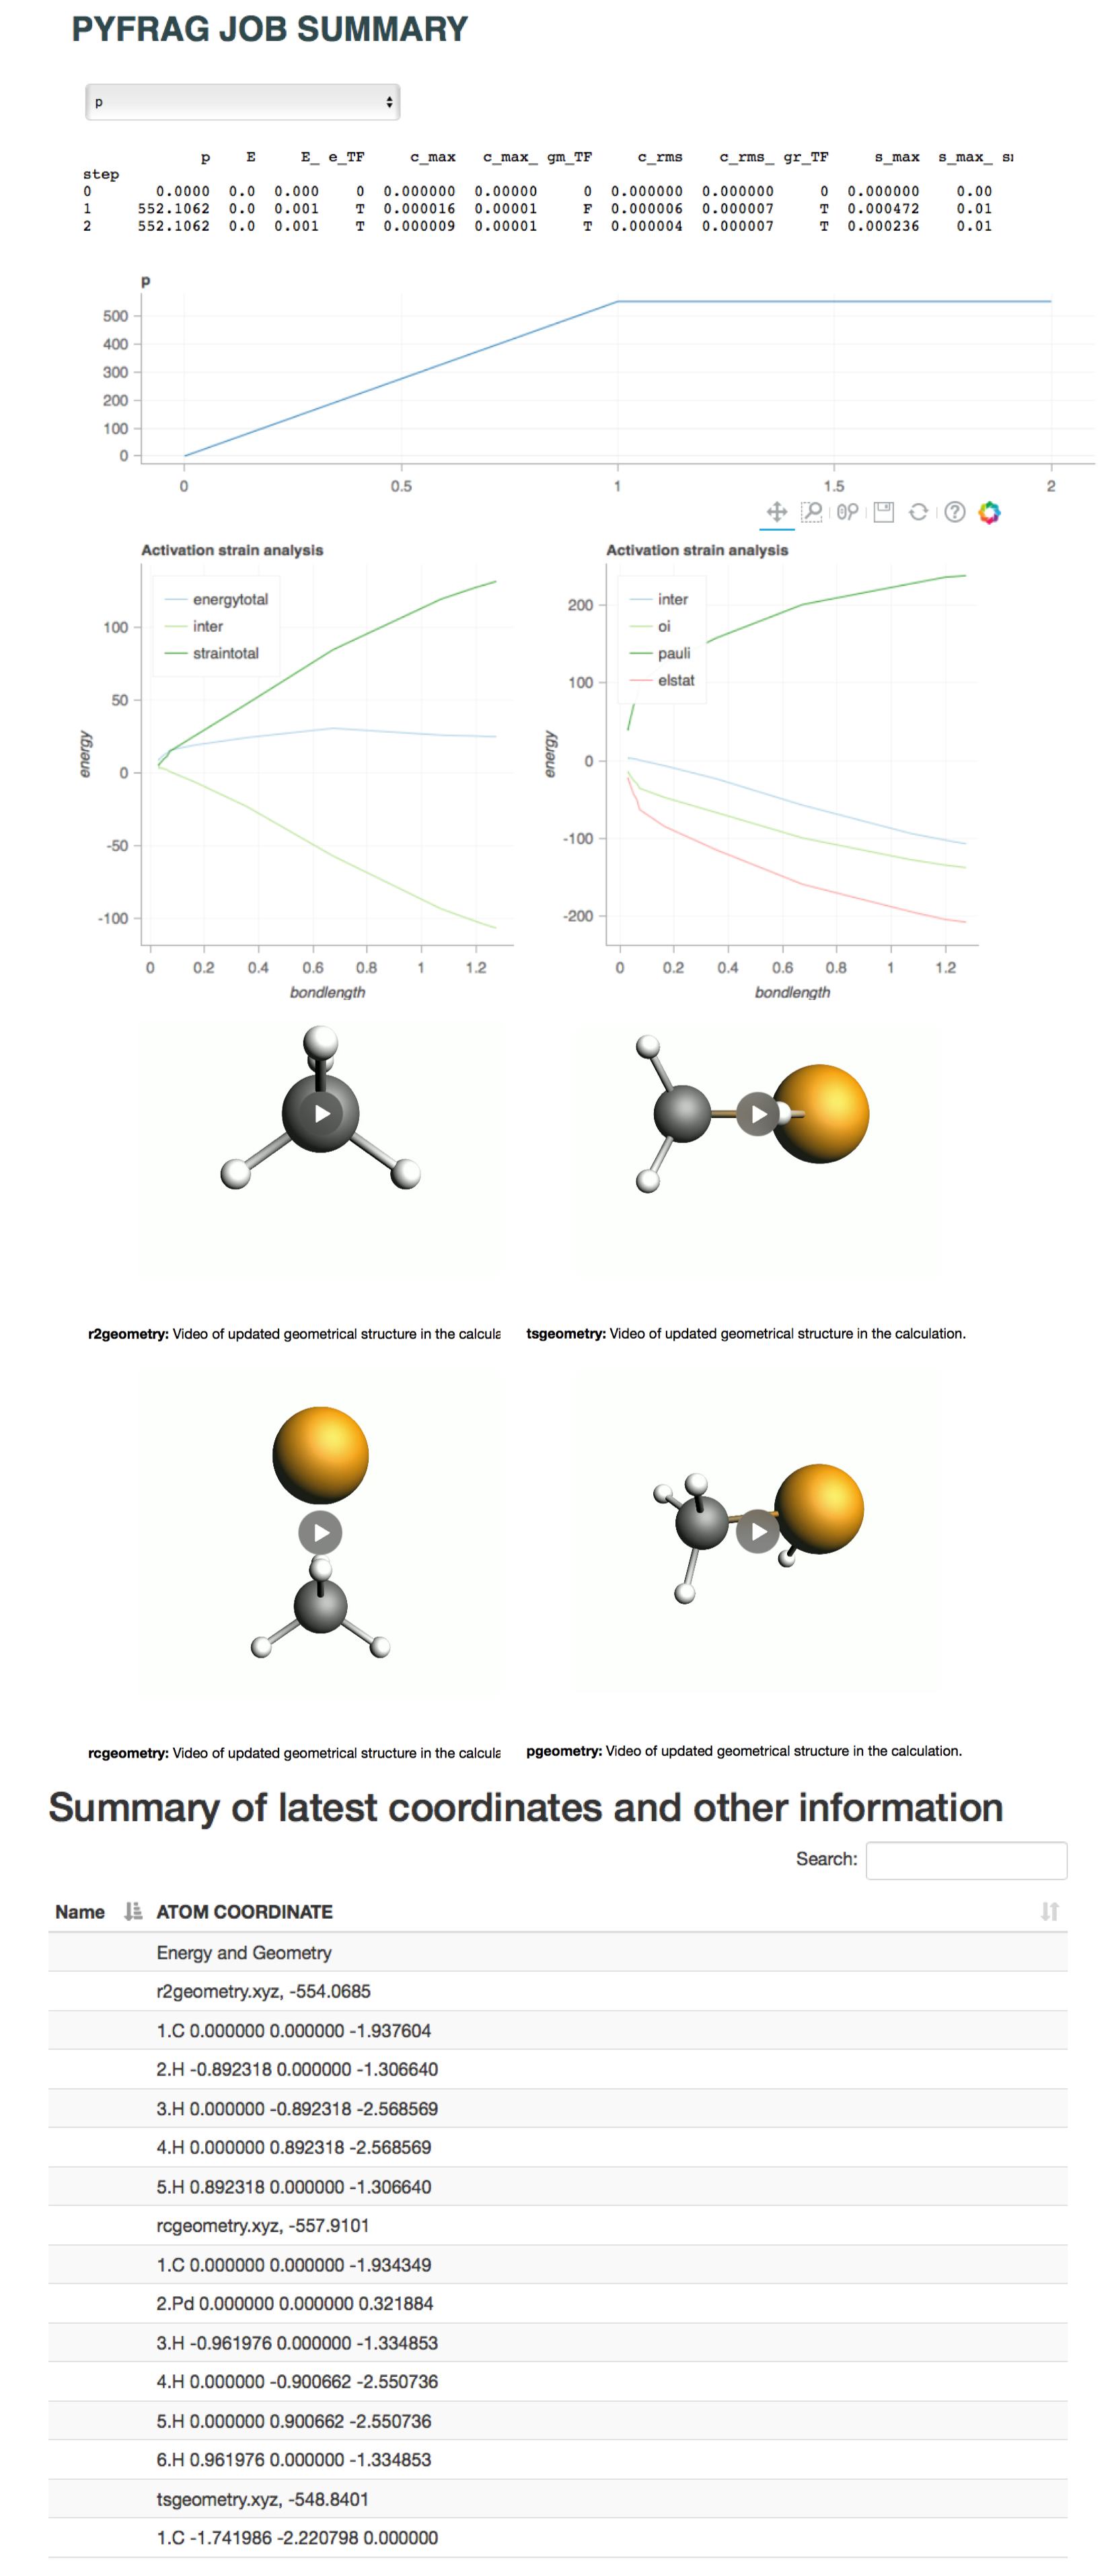

In [2]:
from IPython.display import Image
Image(filename="files/jobresult.png")

###  Job Converge
**The following information related with the job converage is collected.**

```bash
current energy                               -554.1 kcal mol-1
energy change                      -0.00000002     0.00100000    T
constrained gradient max            0.00000715     0.00001000    T
constrained gradient rms            0.00000291     0.00000667    T
gradient max                        0.00000715
gradient rms                        0.00000291
art. step max                       0.00030176     0.01000000    T
cart. step rms                      0.00011623     0.00666667    T 
```
**Y axis of figure represent the current energy (kcal mol-1) which connects with the other terms. Noted the energy is the opposite of the real value which make it easier to plot.**

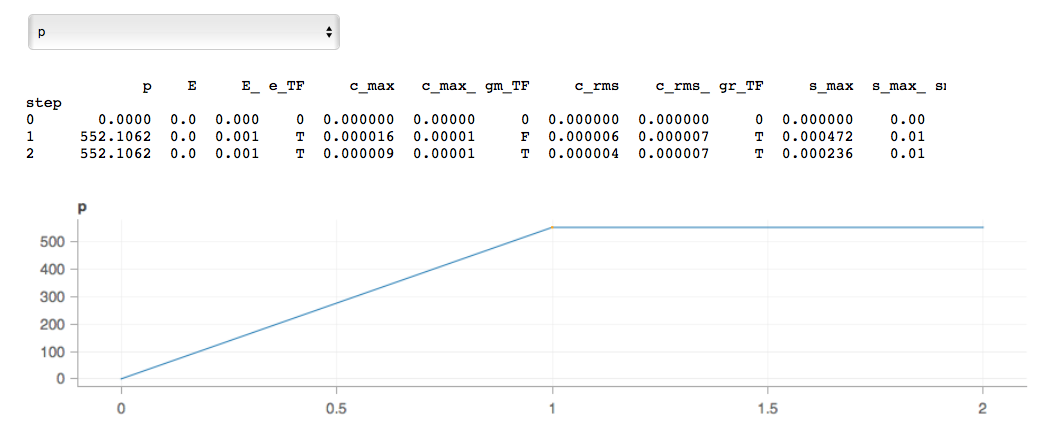

In [9]:
from IPython.display import Image
Image(filename="files/converge_1.png")

**You can choose which structure to show by clicking it name in the square.**

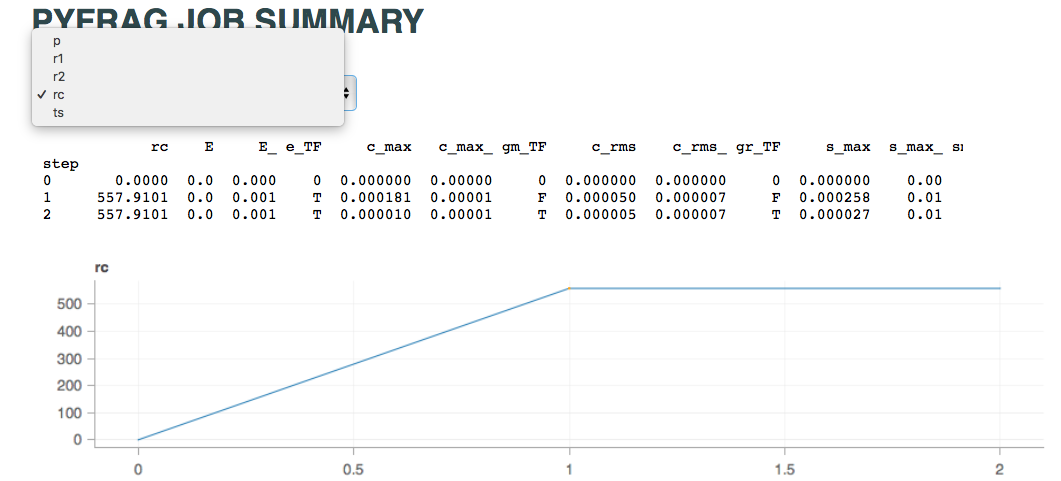

In [5]:
from IPython.display import Image
Image(filename="files/converge_2.png")

**One can also select which point to show by draw a square in the line.**

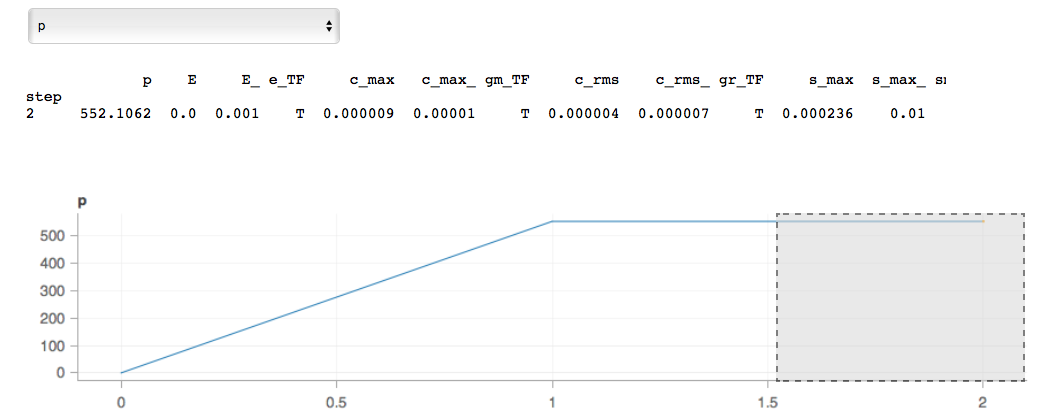

In [6]:
from IPython.display import Image
Image(filename="files/converge_3.png")

###  Geometry Video

**The coresponding video presents a series of geometries. Noted the order is backward, that is, the latest geometry is shown first. In this way, users can always directly look at the latest structure. You can save these videos by right click and save.**

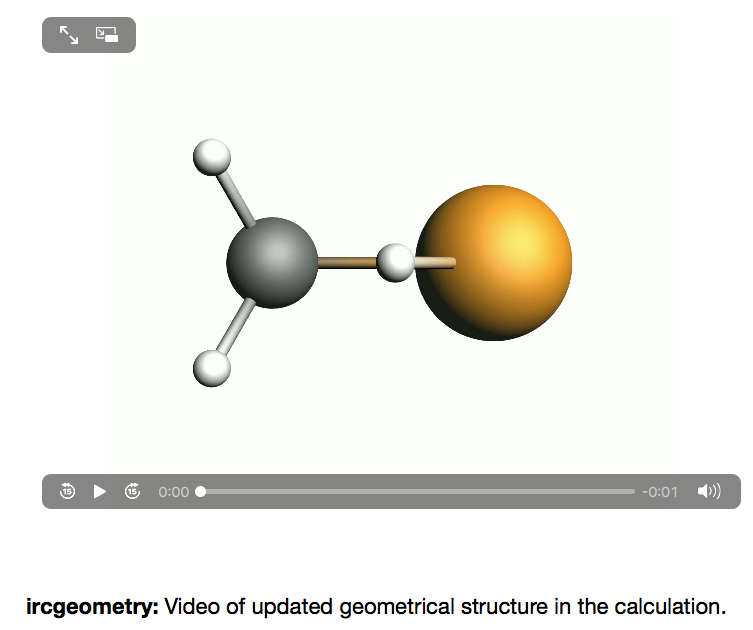

In [7]:
from IPython.display import Image
Image(filename="files/video.png")

###  Geometry Coordinate and Energy
**At last, the latest coordinate and energy for each structure is posted in a table, which can be saved or just selected and copied to the other GUI programs that can visualize molecules.**

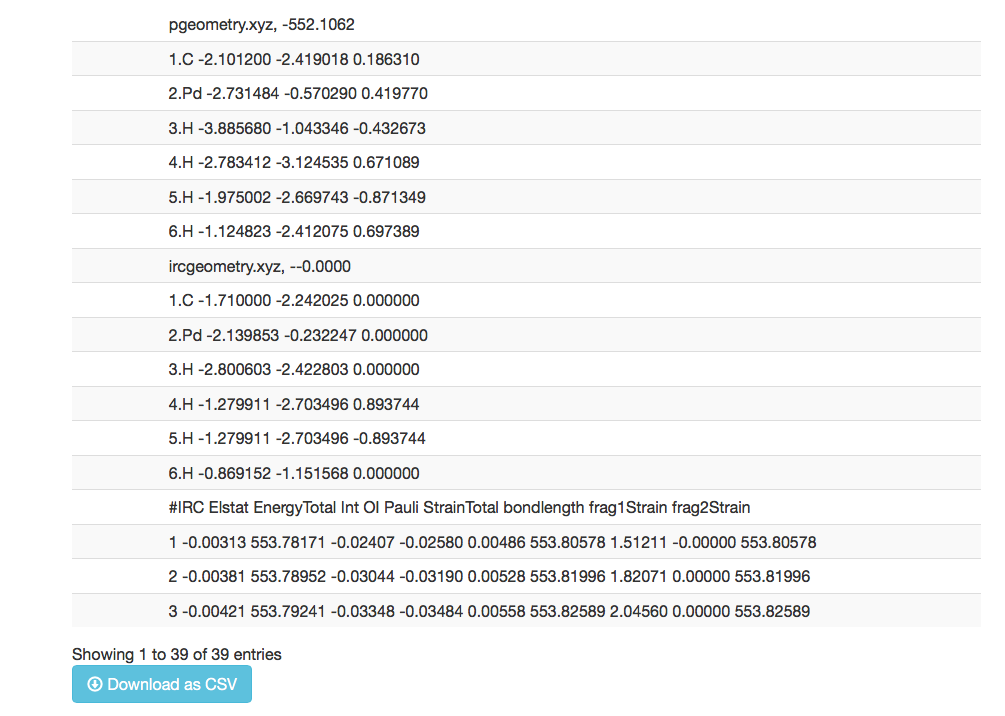

In [11]:
from IPython.display import Image
Image(filename="files/coordinate.png")

###  Activation Strain Model

If an transition state structure is found, IRC (intrisic reactent coordinate) will perform, based on which, an activation strain analysis will carry on. For more information about Activation Strain Model, please check later chapter [Further Information](https://pyfragdocument.readthedocs.io/en/latest/documentation.html). The final figure is as follow which can be saved by clicking the icon of save

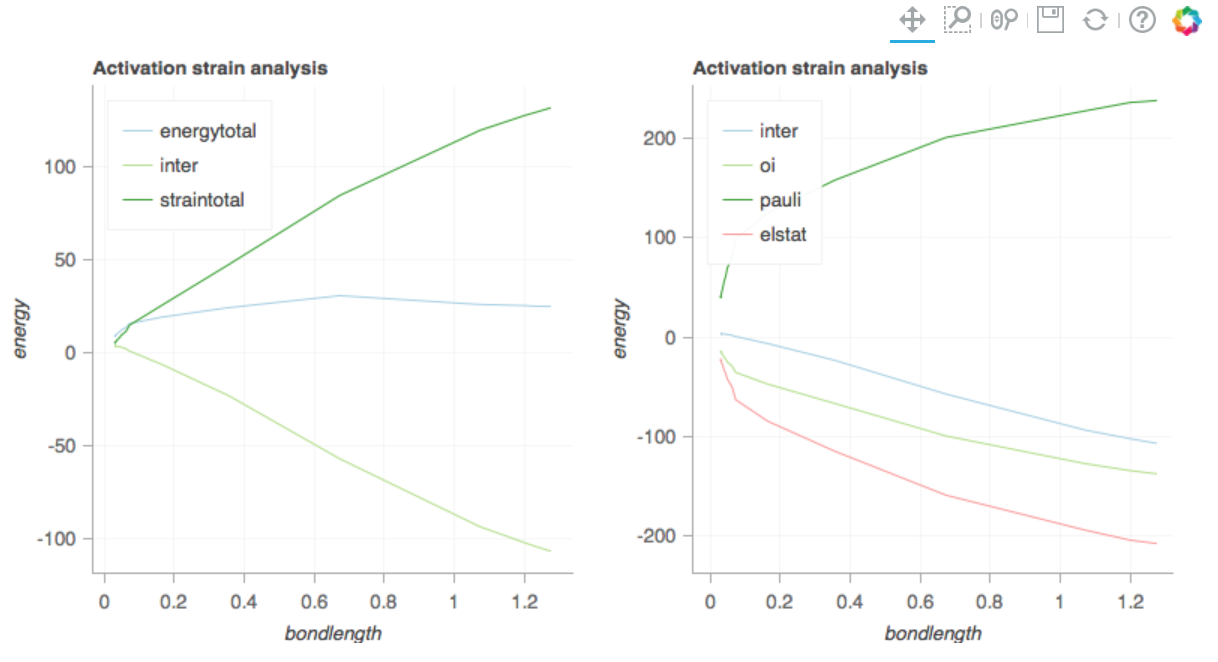

In [1]:
from IPython.display import Image
Image(filename="files/asm.png")

### More Data and Figures

**For these who want to add more information in the ASM, one can simply add more options in `data/result/stocks/change.py` according to the commments.**

```python
if pyfrag_sign==False:
    layout = column(main_row, series)
else:
    from pyfrag import PYFRAG
    # Figure one for ASM which plot energy of total energy, interaction energy and total strain energy
    # againt bondlength change. You can add more data plot by adding a line like:
    # p1.line(PYFRAG['bondlength'], PYFRAG['something'], color='#A6CEE3', legend='something')
    p1 = figure(title="Activation strain analysis")
    p1.grid.grid_line_alpha=0.3
    p1.xaxis.axis_label = 'energy'
    p1.yaxis.axis_label = 'bondlength'

    p1.line(PYFRAG['bondlength'], PYFRAG['energytotal'], color='#A6CEE3', legend='energytotal')
    p1.line(PYFRAG['bondlength'], PYFRAG['inter'],       color='#B2DF8A', legend='inter')
    p1.line(PYFRAG['bondlength'], PYFRAG['straintotal'], color='#33A02C', legend='straintotal')
    p1.legend.location = "top_left"

    # Figure two for ASM which plot the decomposition of interaction energy into
    # orbital, pauli, electronic statistic energy terms.
    p2 = figure(title="Activation strain analysis")
    p2.grid.grid_line_alpha=0.3
    p2.xaxis.axis_label = 'energy'
    p2.yaxis.axis_label = 'bondlength'

    p2.line(PYFRAG['bondlength'], PYFRAG['inter'], color='#A6CEE3', legend='inter')
    p2.line(PYFRAG['bondlength'], PYFRAG['oi'], color='#B2DF8A', legend='oi')
    p2.line(PYFRAG['bondlength'], PYFRAG['pauli'], color='#33A02C', legend='pauli')
    p2.line(PYFRAG['bondlength'], PYFRAG['elstat'], color='#FB9A99', legend='elstat')
    p2.legend.location = "top_left"

    # Lay out the position of two figures and show figures.
    # You can add more figures simply by adding something like:
    # p3 = figure(title="Activation strain analysis")
    # p3.grid.grid_line_alpha=0.3
    # p3.xaxis.axis_label = 'energy'
    # p3.yaxis.axis_label = 'bondlength'
    # p3.line(PYFRAG['bondlength'], PYFRAG['inter'], color='#A6CEE3', legend='inter')
    # p3.line(PYFRAG['bondlength'], PYFRAG['inter'], color='#A6CEE3', legend='inter')
    # p3.legend.location = "top_left"
    # layout = column(main_row, series,gridplot([[p1,p2,p3]], plot_width=400, plot_height=400))

    layout = column(main_row, series,gridplot([[p1,p2]], plot_width=400, plot_height=400))
```

and in the source code of `data/result/stocks/change.py`

```python
def _read_data(name):
    '''
    More data options can be added for instance:
    data = {
    'overlap': [],
    ..............
    }
    and
    for row in reader:
        overlap, irc, ................
        data['overlap'].append(overlap)
    ..............
    '''
    currentPath = os.getcwd()
    filename  = os.path.join(currentPath, str('stocks/PYFRAG.csv'))

    data = {
        'irc' : [],
        'elstat' : [],
        'energytotal' : [],
        'inter' : [],
        'oi' : [],
        'pauli' : [],
        'straintotal' : [],
        'bondlength': [],
        'frag1' : [],
        'frag2' : [],
    }
    with open(filename, 'r') as f:
        next(f)
        reader = csv.reader(f, delimiter=str(','))
        for row in reader:
            irc, elstat, energytotal, inter, oi, pauli, straintotal, bondlength, frag1, frag2 = row
            data['irc'].append(irc)
            data['elstat'].append(float(elstat))
            data['energytotal'].append(float(energytotal))
            data['inter'].append(float(inter))
            data['oi'].append(float(oi))
            data['pauli'].append(float(pauli))
            data['straintotal'].append(float(straintotal))
            data['bondlength'].append(float(bondlength))
            data['frag1'].append(float(frag1))
            data['frag2'].append(float(frag2))
    return data
```

##  Workflow
The rest of the tutorial is to provide an explanation for the code structure. The general structure is listed as follows. Reader is also encouraged to read the code itself where the comments are added in detail. For the functional and class defination of qmworks readers can read the last chapter–[code sturcture](https://pyfragdocument.readthedocs.io/en/latest/app.html).

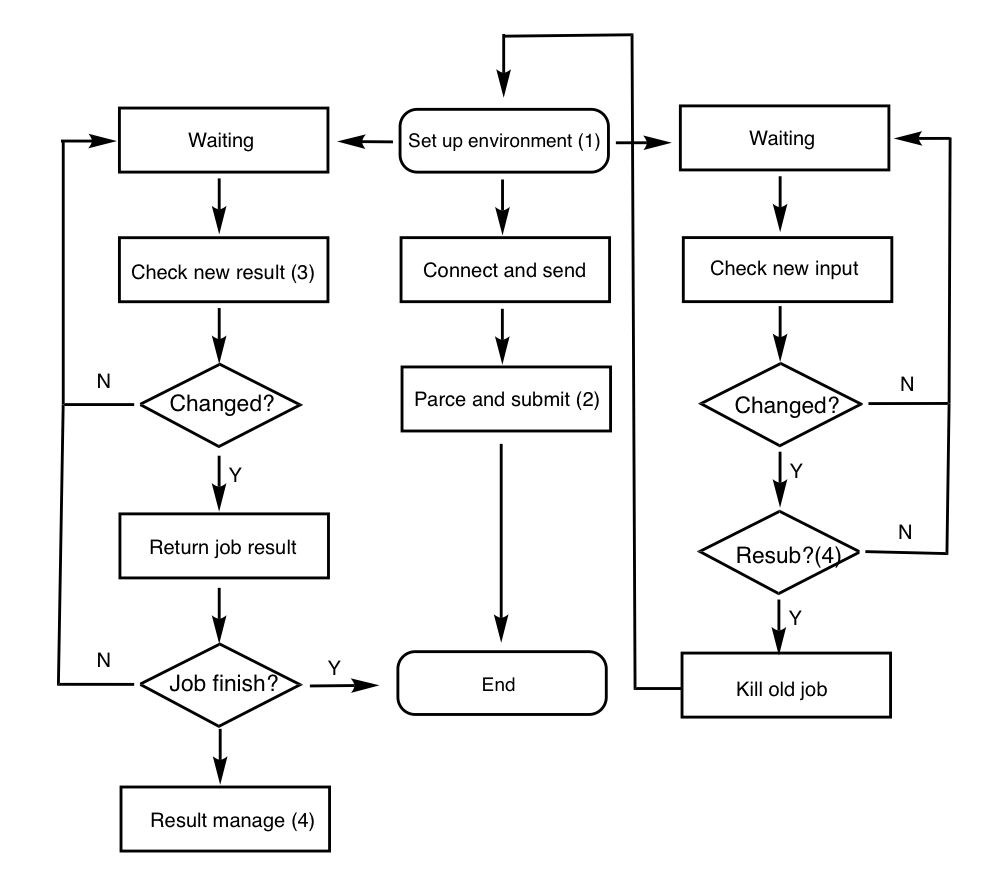

In [13]:
from IPython.display import Image
Image(filename="files/code_flow.png")

```python
Here is a brief introduction of the data flow in the program.

(1) Set up the following information

Create a result dir
Create a video dir 
Create a html dir (stocks)

(2) Parce and submit job

Create a job dir
Parce job input, generate sub file to submit job
Submit job and record job information (jobinfo.txt)

(3) Check if new result exist 

Check if job is finished, if so, change “True” to “False” in jobstate.txt, and return jobstate.txt
Check if geometry and converge information is changed
Create result.txt file to record if any new result generated, if there is any change, return value

(4) Resub

Initiate jobstate.txt (True or False)in both local and remote directory
After job submittion, jobinfo is generated.
Each job check will generate new jobinfo. If converge and geometry is renewed, then will be returned
If jobstate is False, then finish cycle.
```